In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# Standard libraries
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, classification_report,
    accuracy_score
)
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, LSTM, RepeatVector, TimeDistributed,
    Input, Dropout, BatchNormalization
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Print versions
print("="*60)
print("LIBRARY SETUP COMPLETE")
print("="*60)
print(f"Python version: {os.sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}" if 'sklearn' in dir() else "scikit-learn imported")
print(f"Random seed set to: {SEED}")
print("="*60)
print("\n✅ Ready to proceed to Segment 2: Data Loading")

LIBRARY SETUP COMPLETE
Python version: 3.11.13
NumPy version: 1.26.4
Pandas version: 2.2.3
TensorFlow version: 2.18.0
scikit-learn imported
Random seed set to: 42

✅ Ready to proceed to Segment 2: Data Loading


In [31]:
import pandas as pd
import os
import numpy as np # Importing numpy just in case it's needed later

# ===========================
# CONFIGURATION - UPDATE THESE
# ===========================

# Path to your dataset
DATA_PATH = '/kaggle/input/irrigation-machine-dataset/irrigation_machine.csv'

# Name of the label column (e.g., 'label', 'class', 'attack_type')
# Set to None if no labels available (unsupervised)
LABEL_COL = 'label'

# ===========================
# LOAD DATA
# ===========================

print("="*60)
print("LOADING DATASET")
print("="*60)

# Check if file exists
if not os.path.exists(DATA_PATH) or DATA_PATH == 'REPLACE_THIS_WITH_YOUR_ACTUAL_CSV_FILE_PATH.csv':
    print(f"❌ ERROR: File not found at {DATA_PATH}")
    print("\nYou have not updated the DATA_PATH variable yet.")
    print("Please find your .csv file in the Kaggle Input panel on the right,")
    print("copy its path, and paste it into the DATA_PATH variable above.")
else:
    # Load the dataset
    print(f"Loading data from: {DATA_PATH}")
    try:
        # --- FIX FOR PARSER ERROR IS HERE ---
        # We added on_bad_lines='skip' to ignore corrupted rows
        # We added low_memory=False to handle mixed types better in large files
        df = pd.read_csv(DATA_PATH, on_bad_lines='skip', low_memory=False)
        print(f"✅ Data loaded successfully!")

        # Basic information
        print(f"\n📊 DATASET OVERVIEW")
        print(f"{'='*60}")
        print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Column names
        print(f"\n📋 COLUMN NAMES ({len(df.columns)} total):")
        print(f"{'='*60}")
        for i, col in enumerate(df.columns, 1):
            print(f"{i:3d}. {col}")

        # Data types
        print(f"\n📝 DATA TYPES:")
        print(f"{'='*60}")
        dtype_counts = df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"{dtype}: {count} columns")

        # First few rows
        print(f"\n🔍 FIRST 5 ROWS:")
        print(f"{'='*60}")
        print(df.head())

        # Missing values
        print(f"\n❓ MISSING VALUES:")
        print(f"{'='*60}")
        missing = df.isnull().sum()
        missing_pct = (missing / len(df)) * 100
        missing_df = pd.DataFrame({
            'Column': missing.index,
            'Missing Count': missing.values,
            'Percentage': missing_pct.values
        })
        missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

        if len(missing_df) > 0:
            print(missing_df.to_string(index=False))
            print(f"\nTotal columns with missing values: {len(missing_df)}")
        else:
            print("✅ No missing values found!")

        # Check for label column
        print(f"\n🏷️  LABEL COLUMN CHECK:")
        print(f"{'='*60}")
        if LABEL_COL is None:
            print("⚠️  No label column specified - will use unsupervised approach")
            has_labels = False
        elif LABEL_COL in df.columns:
            print(f"✅ Label column '{LABEL_COL}' found!")
            print(f"\nClass distribution:")
            print(df[LABEL_COL].value_counts())
            print(f"\nClass proportions:")
            print(df[LABEL_COL].value_counts(normalize=True) * 100)
            has_labels = True
        else:
            print(f"❌ Label column '{LABEL_COL}' not found in dataset!")
            print(f"\nAvailable columns: {df.columns.tolist()}")
            print("\nPlease update LABEL_COL variable with the correct column name")
            has_labels = False

        # Basic statistics
        print(f"\n📈 DESCRIPTIVE STATISTICS:")
        print(f"{'='*60}")
        print(df.describe())

        # Store information for next segments
        print(f"\n{'='*60}")
        print("DATA LOADING SUMMARY")
        print(f"{'='*60}")
        print(f"✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"✅ Label column: {LABEL_COL if has_labels else 'None (unsupervised)'}")
        print(f"✅ Missing values: {missing.sum()} total")
        print(f"\n✅ Ready to proceed to Segment 3: Data Preprocessing")

    except Exception as e:
        print(f"\n❌ AN ERROR OCCURRED WHILE LOADING:")
        print(e)
        print("\nTip: If this is still a ParserError, your file might use a different separator like ';'")
        print("Try changing the load line to: pd.read_csv(DATA_PATH, sep=';', on_bad_lines='skip')")

LOADING DATASET
Loading data from: /kaggle/input/irrigation-machine-dataset/irrigation_machine.csv
✅ Data loaded successfully!

📊 DATASET OVERVIEW
Shape: 2,000 rows × 24 columns
Memory usage: 0.37 MB

📋 COLUMN NAMES (24 total):
  1. Unnamed: 0
  2. sensor_0
  3. sensor_1
  4. sensor_2
  5. sensor_3
  6. sensor_4
  7. sensor_5
  8. sensor_6
  9. sensor_7
 10. sensor_8
 11. sensor_9
 12. sensor_10
 13. sensor_11
 14. sensor_12
 15. sensor_13
 16. sensor_14
 17. sensor_15
 18. sensor_16
 19. sensor_17
 20. sensor_18
 21. sensor_19
 22. parcel_0
 23. parcel_1
 24. parcel_2

📝 DATA TYPES:
float64: 20 columns
int64: 4 columns

🔍 FIRST 5 ROWS:
   Unnamed: 0  sensor_0  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  parcel_0  parcel_1  parcel_2
0           0       1.0       2.0       1.0       7.0       0.0       1.0       1.0       4.0       0

In [33]:
# ===========================
# CONFIGURATION
# ===========================

TEST_SIZE = 0.2      # 20% for testing
VAL_SIZE = 0.1       # 10% for validation
RANDOM_STATE = SEED  # Use global seed

# ===========================
# STEP 1: SEPARATE FEATURES AND LABELS
# ===========================

print("\n[1/6] Separating features and labels...")

# Separate features and labels
if has_labels and LABEL_COL in df.columns:
    X = df.drop(columns=[LABEL_COL])
    y = df[LABEL_COL]
    
    # Convert labels to binary if needed (0=normal, 1=anomaly)
    # Adjust this based on your dataset
    unique_labels = y.unique()
    print(f"Original labels: {unique_labels}")
    
    # Assume the most common class is "normal" (label 0)
    most_common = y.value_counts().index[0]
    y_binary = (y != most_common).astype(int)
    
    print(f"Label mapping: '{most_common}' → 0 (Normal), Others → 1 (Anomaly)")
    print(f"Class distribution after mapping:")
    print(f"  Normal (0): {(y_binary == 0).sum():,} ({(y_binary == 0).sum()/len(y_binary)*100:.2f}%)")
    print(f"  Anomaly (1): {(y_binary == 1).sum():,} ({(y_binary == 1).sum()/len(y_binary)*100:.2f}%)")
else:
    X = df.copy()
    y_binary = None
    print("No labels - using unsupervised approach")

# ===========================
# STEP 2: SELECT NUMERIC FEATURES
# ===========================

print("\n[2/6] Selecting numeric features...")

# Keep only numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_numeric = X[numeric_cols].copy()

print(f"Selected {len(numeric_cols)} numeric features")
if len(numeric_cols) < len(X.columns):
    dropped = set(X.columns) - set(numeric_cols)
    print(f"Dropped {len(dropped)} non-numeric columns: {list(dropped)[:5]}{'...' if len(dropped) > 5 else ''}")

# ===========================
# STEP 3: HANDLE MISSING VALUES
# ===========================

print("\n[3/6] Handling missing values...")

missing_before = X_numeric.isnull().sum().sum()
print(f"Missing values before: {missing_before:,}")

# Fill missing values with column mean
X_numeric = X_numeric.fillna(X_numeric.mean())

missing_after = X_numeric.isnull().sum().sum()
print(f"Missing values after: {missing_after:,}")
print(f"✅ Filled {missing_before - missing_after:,} missing values with column means")

# ===========================
# STEP 4: TRAIN/VALIDATION/TEST SPLIT
# ===========================

print("\n[4/6] Splitting data into train/validation/test sets...")

if y_binary is not None:
    # Split with stratification
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_numeric, y_binary, 
        test_size=TEST_SIZE, 
        random_state=RANDOM_STATE,
        stratify=y_binary
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=VAL_SIZE/(1-TEST_SIZE),
        random_state=RANDOM_STATE,
        stratify=y_temp
    )
    
    print(f"Training set: {X_train.shape[0]:,} samples")
    print(f"  - Normal: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
    print(f"  - Anomaly: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
    
    print(f"Validation set: {X_val.shape[0]:,} samples")
    print(f"  - Normal: {(y_val == 0).sum():,} ({(y_val == 0).sum()/len(y_val)*100:.1f}%)")
    print(f"  - Anomaly: {(y_val == 1).sum():,} ({(y_val == 1).sum()/len(y_val)*100:.1f}%)")
    
    print(f"Test set: {X_test.shape[0]:,} samples")
    print(f"  - Normal: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
    print(f"  - Anomaly: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")
    
    # Extract only normal samples for training
    normal_mask = (y_train == 0)
    X_train_normal = X_train[normal_mask].copy()
    print(f"\nNormal training samples (for unsupervised training): {len(X_train_normal):,}")
    
else:
    # Split without labels
    X_temp, X_test = train_test_split(
        X_numeric,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    X_train, X_val = train_test_split(
        X_temp,
        test_size=VAL_SIZE/(1-TEST_SIZE),
        random_state=RANDOM_STATE
    )
    
    y_train = y_val = y_test = None
    X_train_normal = X_train.copy()
    
    print(f"Training set: {X_train.shape[0]:,} samples")
    print(f"Validation set: {X_val.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")

# ===========================
# STEP 5: FEATURE SCALING
# ===========================

print("\n[5/6] Scaling features (StandardScaler)...")

# Initialize scaler
scaler = StandardScaler()

# Fit on normal training data only
scaler.fit(X_train_normal)

# Transform all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_normal_scaled = scaler.transform(X_train_normal)

print(f"✅ Features scaled to mean=0, std=1")
print(f"Feature range after scaling: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")

# ===========================
# STEP 6: STORE PREPROCESSED DATA
# ===========================

print("\n[6/6] Storing preprocessed data...")

# Store in a dictionary for easy access
preprocessed_data = {
    'X_train': X_train_scaled,
    'X_val': X_val_scaled,
    'X_test': X_test_scaled,
    'X_train_normal': X_train_normal_scaled,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'feature_names': numeric_cols,
    'n_features': X_train_scaled.shape[1],
    'scaler': scaler
}

# Print summary
print(f"✅ Preprocessed data stored in 'preprocessed_data' dictionary")

print(f"\n{'='*60}")
print("PREPROCESSING SUMMARY")
print(f"{'='*60}")
print(f"Number of features: {preprocessed_data['n_features']}")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"  - Normal samples for training: {len(X_train_normal_scaled):,}")
print(f"Validation samples: {len(X_val_scaled):,}")
print(f"Test samples: {len(X_test_scaled):,}")
print(f"Feature scaling: StandardScaler (mean=0, std=1)")
print(f"\n✅ Ready to proceed to Segment 4: Build Models")


[1/6] Separating features and labels...
No labels - using unsupervised approach

[2/6] Selecting numeric features...
Selected 24 numeric features

[3/6] Handling missing values...
Missing values before: 0
Missing values after: 0
✅ Filled 0 missing values with column means

[4/6] Splitting data into train/validation/test sets...
Training set: 1,400 samples
Validation set: 200 samples
Test set: 400 samples

[5/6] Scaling features (StandardScaler)...
✅ Features scaled to mean=0, std=1
Feature range after scaling: [-1.95, 5.93]

[6/6] Storing preprocessed data...
✅ Preprocessed data stored in 'preprocessed_data' dictionary

PREPROCESSING SUMMARY
Number of features: 24
Training samples: 1,400
  - Normal samples for training: 1,400
Validation samples: 200
Test samples: 400
Feature scaling: StandardScaler (mean=0, std=1)

✅ Ready to proceed to Segment 4: Build Models


In [34]:
print("="*60)
print("BUILDING MODEL ARCHITECTURES")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================

ENCODING_DIM = 32        # Bottleneck dimension for autoencoder
DROPOUT_RATE = 0.2       # Dropout rate for regularization
SEQUENCE_LENGTH = 10     # Sequence length for LSTM

# ===========================
# FUNCTION: BUILD AUTOENCODER
# ===========================

def build_autoencoder(input_dim, encoding_dim=32, dropout_rate=0.2):
    """
    Build a deep autoencoder for anomaly detection
    
    Args:
        input_dim: Number of input features
        encoding_dim: Dimension of the bottleneck layer
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Compiled autoencoder model
    """
    # Encoder
    input_layer = Input(shape=(input_dim,), name='input')
    
    # First encoding layer
    encoded = Dense(128, activation='relu', name='encoder_1')(input_layer)
    encoded = BatchNormalization(name='bn_1')(encoded)
    encoded = Dropout(dropout_rate, name='dropout_1')(encoded)
    
    # Second encoding layer
    encoded = Dense(64, activation='relu', name='encoder_2')(encoded)
    encoded = BatchNormalization(name='bn_2')(encoded)
    encoded = Dropout(dropout_rate, name='dropout_2')(encoded)
    
    # Bottleneck layer (compressed representation)
    encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    # First decoding layer
    decoded = Dense(64, activation='relu', name='decoder_1')(encoded)
    decoded = BatchNormalization(name='bn_3')(decoded)
    decoded = Dropout(dropout_rate, name='dropout_3')(decoded)
    
    # Second decoding layer
    decoded = Dense(128, activation='relu', name='decoder_2')(decoded)
    decoded = BatchNormalization(name='bn_4')(decoded)
    decoded = Dropout(dropout_rate, name='dropout_4')(decoded)
    
    # Output layer (reconstruction)
    output_layer = Dense(input_dim, activation='linear', name='output')(decoded)
    
    # Create model
    autoencoder = Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
    
    # Compile model
    autoencoder.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return autoencoder

# ===========================
# FUNCTION: BUILD LSTM AUTOENCODER
# ===========================

def build_lstm_autoencoder(input_dim, sequence_length=10, encoding_dim=32, dropout_rate=0.2):
    """
    Build LSTM-based autoencoder for time-series anomaly detection
    
    Args:
        input_dim: Number of input features
        sequence_length: Length of input sequences
        encoding_dim: Dimension of LSTM hidden state
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Compiled LSTM autoencoder model
    """
    # Encoder
    inputs = Input(shape=(sequence_length, input_dim), name='input')
    
    # First LSTM layer
    encoded = LSTM(64, activation='relu', return_sequences=True, name='lstm_encoder_1')(inputs)
    encoded = Dropout(dropout_rate, name='dropout_1')(encoded)
    
    # Second LSTM layer (bottleneck)
    encoded = LSTM(encoding_dim, activation='relu', return_sequences=False, name='lstm_bottleneck')(encoded)
    
    # Decoder
    # Repeat encoded state for sequence length
    decoded = RepeatVector(sequence_length, name='repeat')(encoded)
    
    # First LSTM decoder layer
    decoded = LSTM(encoding_dim, activation='relu', return_sequences=True, name='lstm_decoder_1')(decoded)
    decoded = Dropout(dropout_rate, name='dropout_2')(decoded)
    
    # Second LSTM decoder layer
    decoded = LSTM(64, activation='relu', return_sequences=True, name='lstm_decoder_2')(decoded)
    
    # Output layer (reconstruction)
    output_layer = TimeDistributed(Dense(input_dim), name='output')(decoded)
    
    # Create model
    lstm_autoencoder = Model(inputs=inputs, outputs=output_layer, name='lstm_autoencoder')
    
    # Compile model
    lstm_autoencoder.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return lstm_autoencoder

# ===========================
# BUILD AUTOENCODER
# ===========================

print("\n[1/2] Building Autoencoder...")

input_dim = preprocessed_data['n_features']
autoencoder = build_autoencoder(
    input_dim=input_dim,
    encoding_dim=ENCODING_DIM,
    dropout_rate=DROPOUT_RATE
)

print("✅ Autoencoder built successfully!")
print(f"\nAutoencoder Architecture:")
print(f"{'='*60}")
autoencoder.summary()

# Count parameters
total_params = autoencoder.count_params()
print(f"\nTotal parameters: {total_params:,}")

# ===========================
# BUILD LSTM AUTOENCODER
# ===========================

print(f"\n[2/2] Building LSTM Autoencoder...")

lstm_autoencoder = build_lstm_autoencoder(
    input_dim=input_dim,
    sequence_length=SEQUENCE_LENGTH,
    encoding_dim=ENCODING_DIM,
    dropout_rate=DROPOUT_RATE
)

print("✅ LSTM Autoencoder built successfully!")
print(f"\nLSTM Autoencoder Architecture:")
print(f"{'='*60}")
lstm_autoencoder.summary()

# Count parameters
total_params_lstm = lstm_autoencoder.count_params()
print(f"\nTotal parameters: {total_params_lstm:,}")

# ===========================
# STORE MODELS
# ===========================

# Store models in dictionary
models = {
    'autoencoder': autoencoder,
    'lstm_autoencoder': lstm_autoencoder
}

print(f"\n{'='*60}")
print("MODEL BUILDING SUMMARY")
print(f"{'='*60}")
print(f"✅ Autoencoder: {total_params:,} parameters")
print(f"✅ LSTM Autoencoder: {total_params_lstm:,} parameters")
print(f"✅ Models stored in 'models' dictionary")
print(f"\n✅ Ready to proceed to Segment 5: Train Models")

# ===========================
# BASELINE MODELS (WILL BE TRAINED IN NEXT SEGMENT)
# ===========================

print(f"\n📝 Note: Baseline models (Isolation Forest, One-Class SVM)")
print(f"         will be trained in Segment 5")

BUILDING MODEL ARCHITECTURES

[1/2] Building Autoencoder...
✅ Autoencoder built successfully!

Autoencoder Architecture:


2026-01-13 18:51:14.637542: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,600 (111.72 KB)

 Trainable params: 27,832 (108.72 KB)

 Non-trainable params: 768 (3.00 KB)


Total parameters: 28,600

[2/2] Building LSTM Autoencoder...
✅ LSTM Autoencoder built successfully!

LSTM Autoencoder Architecture:


Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_encoder_1 (LSTM)           │ (None, 10, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_bottleneck (LSTM)          │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat (RepeatVector)           │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_decoder_1 (LSTM)           │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_decoder_2 (LSTM)           │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (TimeDistributed)        │ (None, 10, 24)         │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,912 (273.09 KB)

 Trainable params: 69,912 (273.09 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 69,912

MODEL BUILDING SUMMARY
✅ Autoencoder: 28,600 parameters
✅ LSTM Autoencoder: 69,912 parameters
✅ Models stored in 'models' dictionary

✅ Ready to proceed to Segment 5: Train Models

📝 Note: Baseline models (Isolation Forest, One-Class SVM)
         will be trained in Segment 5


In [35]:
print("="*60)
print("TRAINING MODELS")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================

EPOCHS = 100              # Maximum number of epochs
BATCH_SIZE = 32          # Batch size for training
PATIENCE = 10            # Early stopping patience
CONTAMINATION = 0.1      # Expected proportion of anomalies (for baselines)

# ===========================
# PART 1: TRAIN AUTOENCODER
# ===========================

print("\n" + "="*60)
print("PART 1: TRAINING AUTOENCODER")
print("="*60)

# Get data
X_train_normal = preprocessed_data['X_train_normal']
X_val = preprocessed_data['X_val']

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print(f"\nTraining Configuration:")
print(f"  - Training samples: {len(X_train_normal):,} (normal only)")
print(f"  - Validation samples: {len(X_val):,}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Max epochs: {EPOCHS}")
print(f"  - Early stopping patience: {PATIENCE}")
print(f"\nStarting training...\n")

# Train autoencoder
history_ae = models['autoencoder'].fit(
    X_train_normal,
    X_train_normal,  # Autoencoder tries to reconstruct input
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Autoencoder training complete!")

# Get final metrics
final_train_loss = history_ae.history['loss'][-1]
final_val_loss = history_ae.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")
print(f"Epochs trained: {len(history_ae.history['loss'])}")

# ===========================
# PART 2: TRAIN BASELINE MODELS
# ===========================

print("\n" + "="*60)
print("PART 2: TRAINING BASELINE MODELS")
print("="*60)

# Initialize baseline models dictionary
baseline_models = {}

# ---------------------------
# 2.1: Isolation Forest
# ---------------------------

print("\n[1/2] Training Isolation Forest...")

iso_forest = IsolationForest(
    contamination=CONTAMINATION,
    random_state=SEED,
    n_estimators=100,
    n_jobs=-1,
    verbose=0
)

iso_forest.fit(X_train_normal)
baseline_models['isolation_forest'] = iso_forest

print("✅ Isolation Forest trained!")
print(f"  - Training samples: {len(X_train_normal):,}")
print(f"  - Contamination: {CONTAMINATION}")
print(f"  - Number of trees: 100")

# ---------------------------
# 2.2: One-Class SVM
# ---------------------------

print("\n[2/2] Training One-Class SVM...")
print("  (This may take a few minutes...)")

oc_svm = OneClassSVM(
    nu=CONTAMINATION,
    kernel='rbf',
    gamma='auto'
)

oc_svm.fit(X_train_normal)
baseline_models['one_class_svm'] = oc_svm

print("✅ One-Class SVM trained!")
print(f"  - Training samples: {len(X_train_normal):,}")
print(f"  - Nu (contamination): {CONTAMINATION}")
print(f"  - Kernel: RBF")

# ===========================
# PART 3: OPTIONAL - TRAIN LSTM AUTOENCODER
# ===========================

print("\n" + "="*60)
print("PART 3: LSTM AUTOENCODER (OPTIONAL)")
print("="*60)
print("\n⚠️  LSTM Autoencoder requires sequence data.")
print("This takes longer to train and requires more memory.")

train_lstm = input("\nDo you want to train LSTM Autoencoder? (y/n): ").lower().strip()

if train_lstm == 'y':
    print("\nPreparing sequence data...")
    
    # Function to create sequences
    def create_sequences(data, sequence_length):
        sequences = []
        for i in range(len(data) - sequence_length + 1):
            sequences.append(data[i:i+sequence_length])
        return np.array(sequences)
    
    # Create sequences
    X_train_normal_seq = create_sequences(X_train_normal, SEQUENCE_LENGTH)
    X_val_seq = create_sequences(X_val, SEQUENCE_LENGTH)
    
    print(f"  - Training sequences: {len(X_train_normal_seq):,}")
    print(f"  - Validation sequences: {len(X_val_seq):,}")
    print(f"  - Sequence shape: {X_train_normal_seq.shape}")
    
    print(f"\nStarting LSTM training...\n")
    
    # Train LSTM autoencoder
    history_lstm = models['lstm_autoencoder'].fit(
        X_train_normal_seq,
        X_train_normal_seq,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_seq, X_val_seq),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    print("\n✅ LSTM Autoencoder training complete!")
    
    # Get final metrics
    final_train_loss_lstm = history_lstm.history['loss'][-1]
    final_val_loss_lstm = history_lstm.history['val_loss'][-1]
    print(f"\nFinal Training Loss: {final_train_loss_lstm:.6f}")
    print(f"Final Validation Loss: {final_val_loss_lstm:.6f}")
    print(f"Epochs trained: {len(history_lstm.history['loss'])}")
    
    # Store sequence data
    sequence_data = {
        'X_train_seq': X_train_normal_seq,
        'X_val_seq': X_val_seq
    }
    
else:
    print("\n⏭️  Skipping LSTM Autoencoder training")
    history_lstm = None
    sequence_data = None

# ===========================
# STORE TRAINING RESULTS
# ===========================

print("\n" + "="*60)
print("STORING TRAINING RESULTS")
print("="*60)

# Store all models
all_models = {
    'autoencoder': models['autoencoder'],
    'lstm_autoencoder': models['lstm_autoencoder'] if train_lstm == 'y' else None,
    'isolation_forest': baseline_models['isolation_forest'],
    'one_class_svm': baseline_models['one_class_svm']
}

# Store training histories
training_histories = {
    'autoencoder': history_ae,
    'lstm_autoencoder': history_lstm if train_lstm == 'y' else None
}

print("✅ All models and histories stored!")

# ===========================
# TRAINING SUMMARY
# ===========================

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"\n✅ Autoencoder")
print(f"  - Status: Trained")
print(f"  - Final validation loss: {final_val_loss:.6f}")
print(f"  - Epochs: {len(history_ae.history['loss'])}")

if train_lstm == 'y':
    print(f"\n✅ LSTM Autoencoder")
    print(f"  - Status: Trained")
    print(f"  - Final validation loss: {final_val_loss_lstm:.6f}")
    print(f"  - Epochs: {len(history_lstm.history['loss'])}")
else:
    print(f"\n⏭️  LSTM Autoencoder")
    print(f"  - Status: Skipped")

print(f"\n✅ Isolation Forest")
print(f"  - Status: Trained")
print(f"  - Training samples: {len(X_train_normal):,}")

print(f"\n✅ One-Class SVM")
print(f"  - Status: Trained")
print(f"  - Training samples: {len(X_train_normal):,}")

print(f"\n{'='*60}")
print("✅ All models trained successfully!")
print("✅ Ready to proceed to Segment 6: Evaluate Models")
print("="*60)

TRAINING MODELS

PART 1: TRAINING AUTOENCODER

Training Configuration:
  - Training samples: 1,400 (normal only)
  - Validation samples: 200
  - Batch size: 32
  - Max epochs: 100
  - Early stopping patience: 10

Starting training...

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.5618 - mae: 1.2595 - val_loss: 0.9556 - val_mae: 0.7990 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5466 - mae: 0.9828 - val_loss: 0.9003 - val_mae: 0.7713 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2711 - mae: 0.8884 - val_loss: 0.8221 - val_mae: 0.7324 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0939 - mae: 0.8279 - val_loss: 0.7464 - val_mae: 0.6922 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9817 - mae: 0.7811 - val_loss: 0.6825 - val_mae: 0.6595 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 


Do you want to train LSTM Autoencoder? (y/n):  y



Preparing sequence data...
  - Training sequences: 1,391
  - Validation sequences: 191
  - Sequence shape: (1391, 10, 24)

Starting LSTM training...

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.9987 - mae: 0.8136 - val_loss: 0.9732 - val_mae: 0.8034 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9870 - mae: 0.8064 - val_loss: 0.9477 - val_mae: 0.7881 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9700 - mae: 0.7966 - val_loss: 0.9398 - val_mae: 0.7840 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9624 - mae: 0.7928 - val_loss: 0.9344 - val_mae: 0.7797 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9564 - mae: 0.7894 - val_loss: 0.9289 - val_mae: 0.7763 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.9510 - mae: 0.7863 - val_loss: 0.9205 - val_mae: 0.7733 - learning_rate: 0.0

In [41]:
print("="*60)
print("MODEL EVALUATION")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================

THRESHOLD_PERCENTILE = 95  # Percentile for reconstruction error threshold

# ===========================
# GET TEST DATA
# ===========================

X_test = preprocessed_data['X_test']
y_test = preprocessed_data['y_test']

if y_test is not None:
    print(f"Test set: {len(X_test):,} samples")
    print(f"  - Normal: {(y_test == 0).sum():,}")
    print(f"  - Anomaly: {(y_test == 1).sum():,}")
else:
    print(f"Test set: {len(X_test):,} samples")
    print("⚠️  No labels available - will show predictions only")

# ===========================
# PART 1: AUTOENCODER PREDICTIONS
# ===========================

print("\n" + "="*60)
print("PART 1: AUTOENCODER EVALUATION")
print("="*60)

# Get autoencoder model
autoencoder_model = all_models['autoencoder']

# Make predictions (reconstructions)
print("\nCalculating reconstruction errors...")
X_test_pred = autoencoder_model.predict(X_test, verbose=0)

# Calculate reconstruction error (MSE per sample)
reconstruction_errors = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Determine threshold
threshold_ae = np.percentile(reconstruction_errors, THRESHOLD_PERCENTILE)
print(f"Reconstruction error threshold ({THRESHOLD_PERCENTILE}th percentile): {threshold_ae:.6f}")

# Classify: error > threshold = anomaly
y_pred_ae = (reconstruction_errors > threshold_ae).astype(int)

print(f"\nPredictions:")
print(f"  - Predicted Normal: {(y_pred_ae == 0).sum():,}")
print(f"  - Predicted Anomaly: {(y_pred_ae == 1).sum():,}")

# Store results
results_ae = {
    'predictions': y_pred_ae,
    'scores': reconstruction_errors,
    'threshold': threshold_ae
}

# ===========================
# PART 2: ISOLATION FOREST PREDICTIONS
# ===========================

print("\n" + "="*60)
print("PART 2: ISOLATION FOREST EVALUATION")
print("="*60)

# Get Isolation Forest model
iso_forest_model = all_models['isolation_forest']

print("\nMaking predictions...")
# Predict: -1 = anomaly, 1 = normal
y_pred_if_raw = iso_forest_model.predict(X_test)
y_pred_if = (y_pred_if_raw == -1).astype(int)  # Convert to 0/1

# Get anomaly scores
scores_if = -iso_forest_model.score_samples(X_test)

print(f"Predictions:")
print(f"  - Predicted Normal: {(y_pred_if == 0).sum():,}")
print(f"  - Predicted Anomaly: {(y_pred_if == 1).sum():,}")

# Store results
results_if = {
    'predictions': y_pred_if,
    'scores': scores_if
}

# ===========================
# PART 3: ONE-CLASS SVM PREDICTIONS
# ===========================

print("\n" + "="*60)
print("PART 3: ONE-CLASS SVM EVALUATION")
print("="*60)

# Get One-Class SVM model
svm_model = all_models['one_class_svm']

print("\nMaking predictions...")
# Predict: -1 = anomaly, 1 = normal
y_pred_svm_raw = svm_model.predict(X_test)
y_pred_svm = (y_pred_svm_raw == -1).astype(int)  # Convert to 0/1

# Get decision scores
scores_svm = -svm_model.decision_function(X_test)

print(f"Predictions:")
print(f"  - Predicted Normal: {(y_pred_svm == 0).sum():,}")
print(f"  - Predicted Anomaly: {(y_pred_svm == 1).sum():,}")

# Store results
results_svm = {
    'predictions': y_pred_svm,
    'scores': scores_svm
}

# ===========================
# PART 4: CALCULATE METRICS (IF LABELS AVAILABLE)
# ===========================

if y_test is not None:
    print("\n" + "="*60)
    print("PART 4: PERFORMANCE METRICS")
    print("="*60)
    
    # Initialize results list
    metrics_list = []
    
    # Function to calculate all metrics
    def calculate_metrics(y_true, y_pred, scores, model_name):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        
        # Calculate ROC-AUC if possible
        try:
            auc = roc_auc_score(y_true, scores)
        except:
            auc = None
        
        return {
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy,
            'ROC-AUC': auc
        }
    
    # Calculate metrics for each model
    print("\n--- Autoencoder ---")
    metrics_ae = calculate_metrics(y_test, y_pred_ae, reconstruction_errors, 'Autoencoder')
    metrics_list.append(metrics_ae)
    print(classification_report(y_test, y_pred_ae, target_names=['Normal', 'Anomaly']))
    
    print("\n--- Isolation Forest ---")
    metrics_if = calculate_metrics(y_test, y_pred_if, scores_if, 'Isolation Forest')
    metrics_list.append(metrics_if)
    print(classification_report(y_test, y_pred_if, target_names=['Normal', 'Anomaly']))
    
    print("\n--- One-Class SVM ---")
    metrics_svm = calculate_metrics(y_test, y_pred_svm, scores_svm, 'One-Class SVM')
    metrics_list.append(metrics_svm)
    print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Anomaly']))
    
    # Create comparison DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    
    # Display comparison table
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    print(metrics_df.to_string(index=False))
    
    # Find best model
    best_model_idx = metrics_df['F1-Score'].idxmax()
    best_model_name = metrics_df.loc[best_model_idx, 'Model']
    best_f1 = metrics_df.loc[best_model_idx, 'F1-Score']
    
    print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")
    
else:
    print("\n⚠️  No labels available - skipping metric calculation")
    metrics_df = None

# ===========================
# STORE ALL RESULTS
# ===========================

print("\n" + "="*60)
print("STORING RESULTS")
print("="*60)

# Store all results
evaluation_results = {
    'autoencoder': results_ae,
    'isolation_forest': results_if,
    'one_class_svm': results_svm,
    'metrics': metrics_df if y_test is not None else None,
    'y_test': y_test
}

print("✅ All evaluation results stored in 'evaluation_results' dictionary")

# ===========================
# EVALUATION SUMMARY
# ===========================

print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)

print(f"\n✅ Models evaluated on {len(X_test):,} test samples")

if y_test is not None:
    print(f"\n📊 Performance Summary:")
    for _, row in metrics_df.iterrows():
        print(f"\n{row['Model']}:")
        print(f"  - Precision: {row['Precision']:.4f}")
        print(f"  - Recall: {row['Recall']:.4f}")
        print(f"  - F1-Score: {row['F1-Score']:.4f}")
        if row['ROC-AUC'] is not None:
            print(f"  - ROC-AUC: {row['ROC-AUC']:.4f}")

print(f"\n{'='*60}")
print("✅ Evaluation complete!")
print("✅ Ready to proceed to Segment 7: Visualizations")
print("="*60)

MODEL EVALUATION
Test set: 400 samples
⚠️  No labels available - will show predictions only

PART 1: AUTOENCODER EVALUATION

Calculating reconstruction errors...
Reconstruction error threshold (95th percentile): 0.206563

Predictions:
  - Predicted Normal: 380
  - Predicted Anomaly: 20

PART 2: ISOLATION FOREST EVALUATION

Making predictions...
Predictions:
  - Predicted Normal: 359
  - Predicted Anomaly: 41

PART 3: ONE-CLASS SVM EVALUATION

Making predictions...
Predictions:
  - Predicted Normal: 341
  - Predicted Anomaly: 59

⚠️  No labels available - skipping metric calculation

STORING RESULTS
✅ All evaluation results stored in 'evaluation_results' dictionary

EVALUATION SUMMARY

✅ Models evaluated on 400 test samples

✅ Evaluation complete!
✅ Ready to proceed to Segment 7: Visualizations


GENERATING VISUALIZATIONS
📁 Created 'figures' directory for saving plots

VISUALIZATION 1: TRAINING HISTORY
✅ Saved: figures/training_history.png


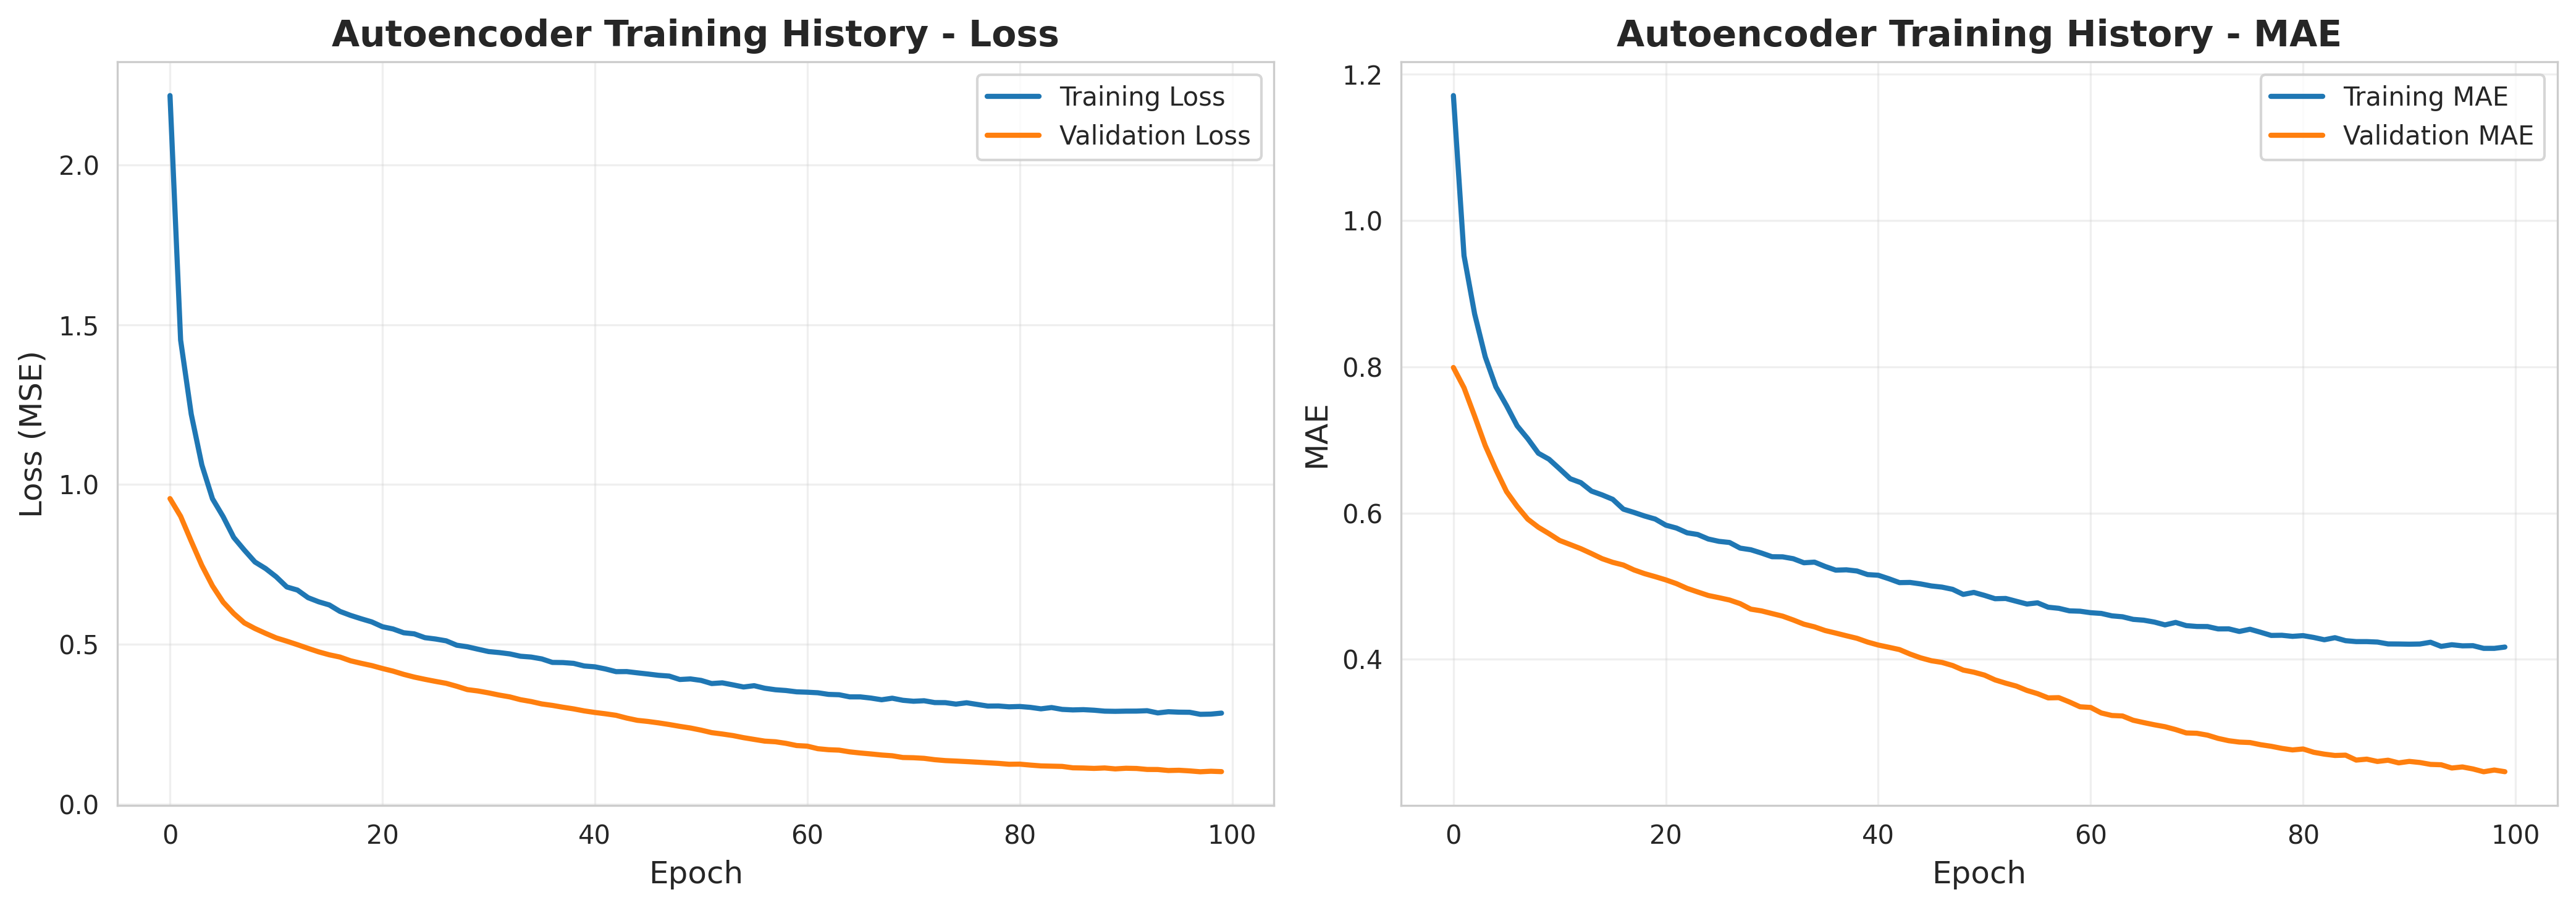


VISUALIZATION 4: RECONSTRUCTION ERROR DISTRIBUTION
✅ Saved: figures/reconstruction_error_distribution.png


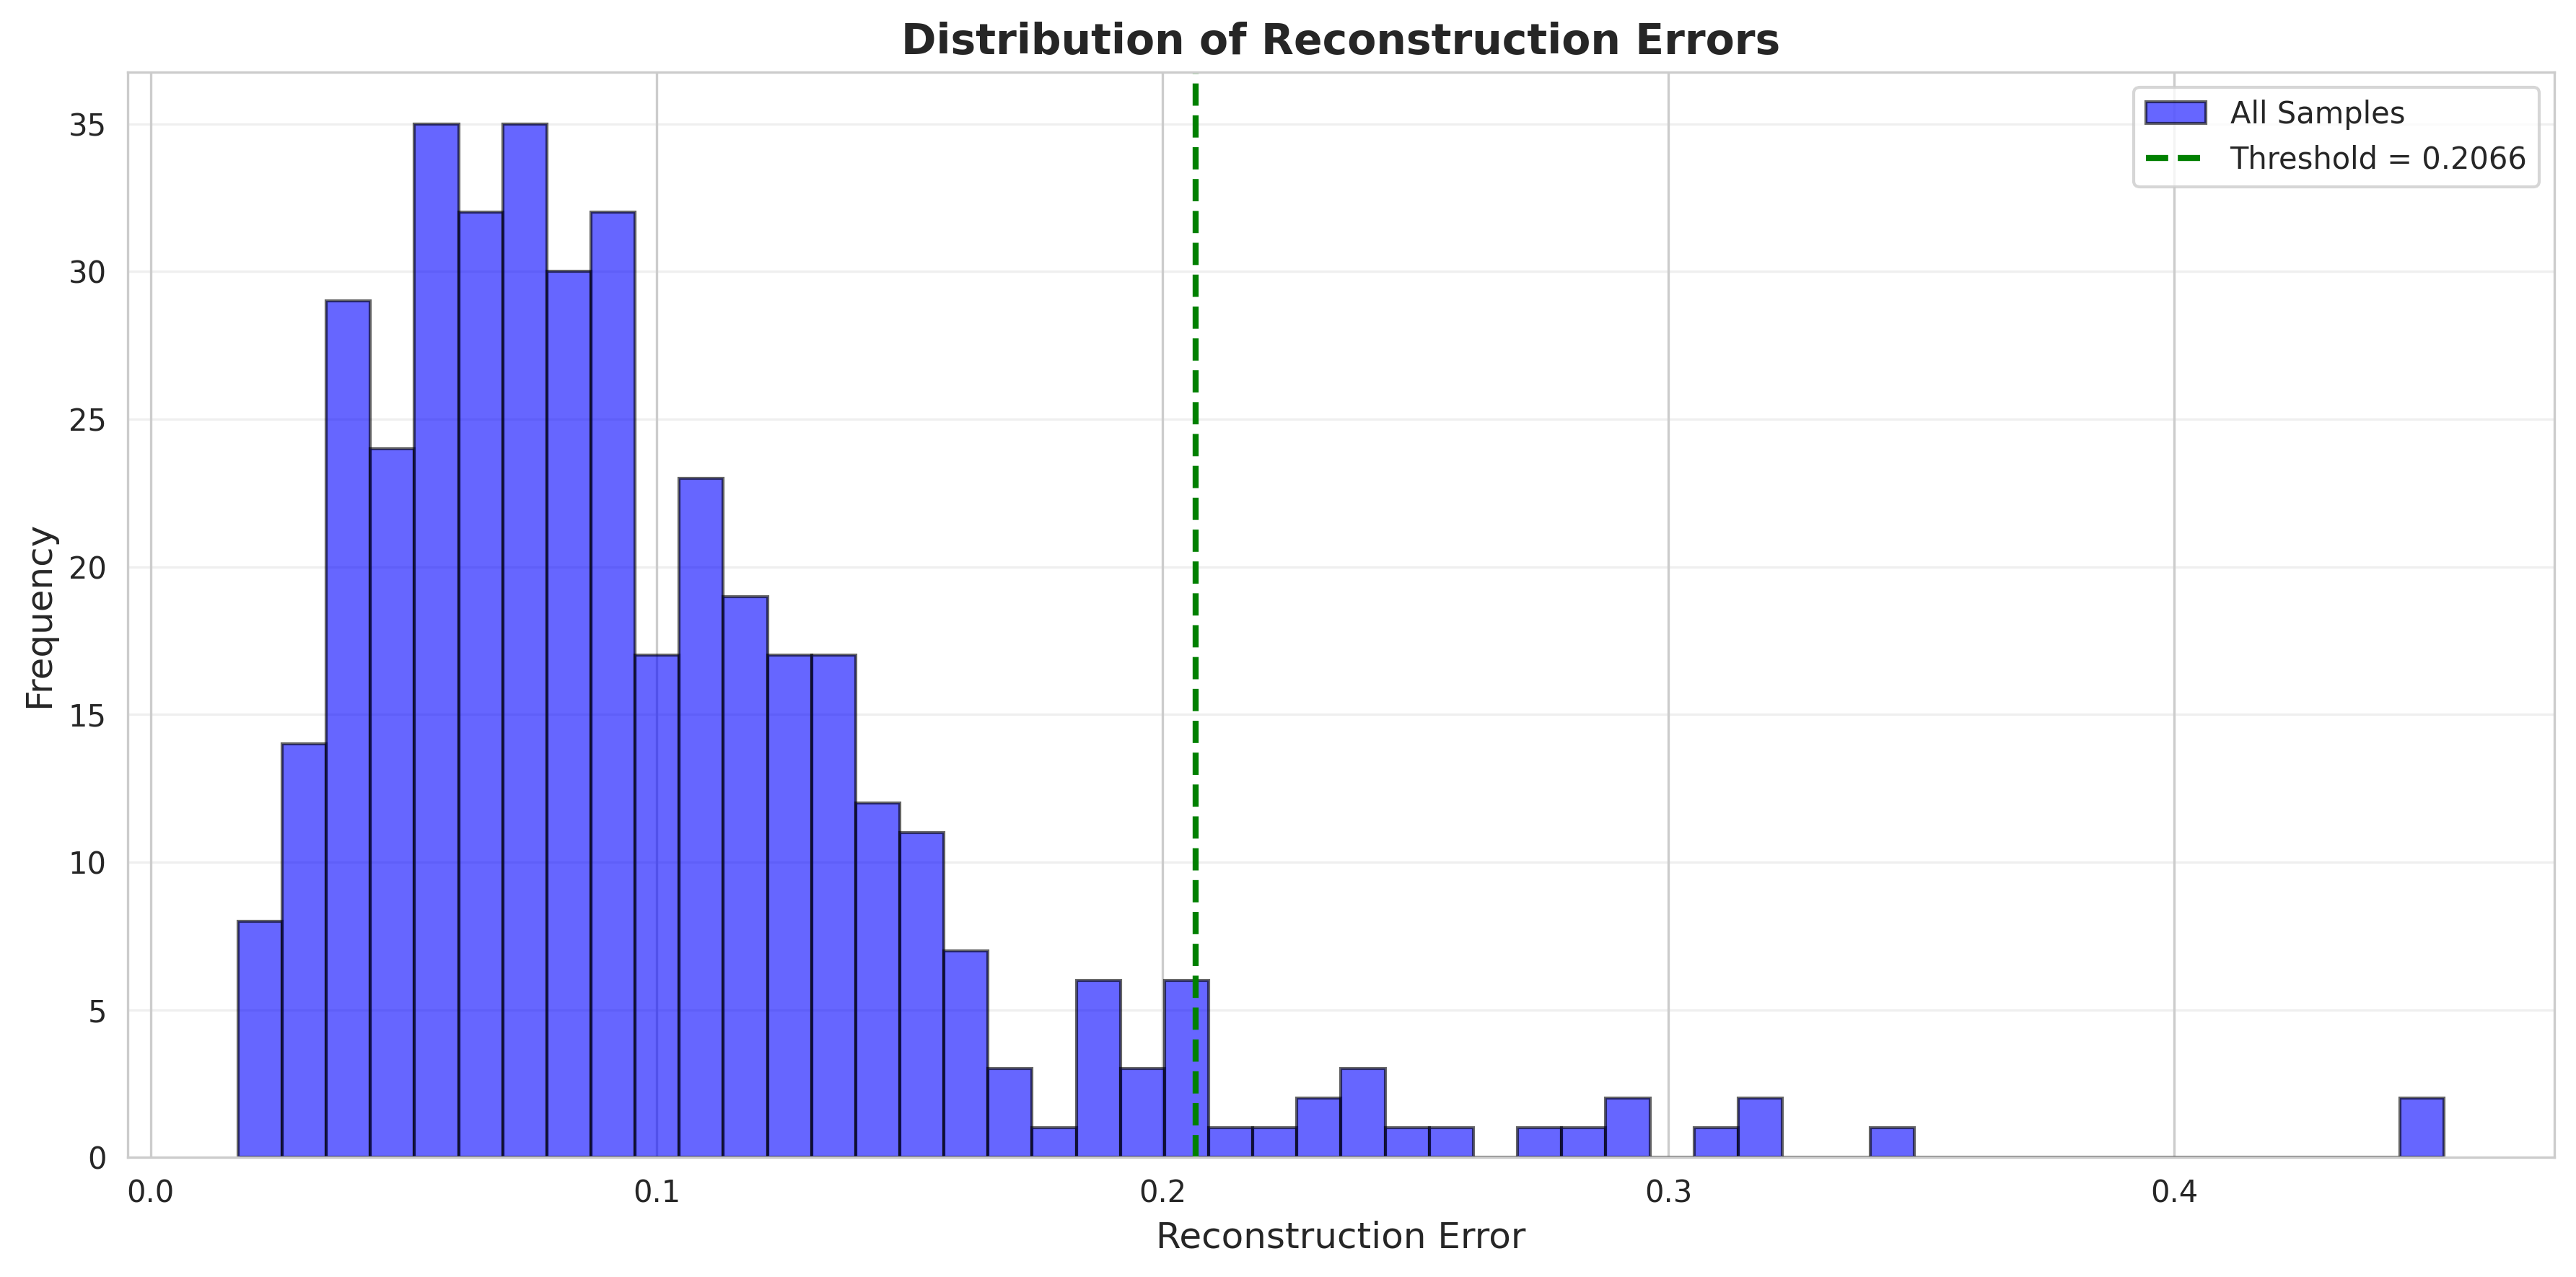


VISUALIZATION SUMMARY

✅ Generated Visualizations:
  1. Training History (Loss & MAE)
  4. Reconstruction Error Distribution

📁 All figures saved in 'figures/' directory
   Resolution: 300 DPI (publication quality)

✅ Visualization generation complete!
✅ Ready to proceed to Segment 8: Save Models & Results


In [42]:
"""
SEGMENT 7: GENERATE VISUALIZATIONS
===================================
Create all visualizations for the research paper.

REQUIREMENTS:
- Must have run Segments 1-6 first
- training_histories and evaluation_results must be defined
"""

print("="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================

# Figure settings for publication quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (10, 6)

# Create output directory for figures
import os
os.makedirs('figures', exist_ok=True)
print("📁 Created 'figures' directory for saving plots\n")

# ===========================
# VISUALIZATION 1: TRAINING HISTORY
# ===========================

print("="*60)
print("VISUALIZATION 1: TRAINING HISTORY")
print("="*60)

# Get autoencoder training history
history = training_histories['autoencoder']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Autoencoder Training History - Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Autoencoder Training History - MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/training_history.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/training_history.png")
plt.show()

# ===========================
# VISUALIZATION 2: CONFUSION MATRICES
# ===========================

if evaluation_results['y_test'] is not None:
    print("\n" + "="*60)
    print("VISUALIZATION 2: CONFUSION MATRICES")
    print("="*60)
    
    y_test = evaluation_results['y_test']
    
    # Get predictions from all models
    models_to_plot = {
        'Autoencoder': evaluation_results['autoencoder']['predictions'],
        'Isolation Forest': evaluation_results['isolation_forest']['predictions'],
        'One-Class SVM': evaluation_results['one_class_svm']['predictions']
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, (model_name, predictions) in enumerate(models_to_plot.items()):
        cm = confusion_matrix(y_test, predictions)
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Normal', 'Anomaly'],
                   yticklabels=['Normal', 'Anomaly'],
                   cbar=True)
        
        axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=11)
        axes[idx].set_xlabel('Predicted Label', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('figures/confusion_matrices.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: figures/confusion_matrices.png")
    plt.show()

# ===========================
# VISUALIZATION 3: ROC CURVES
# ===========================

if evaluation_results['y_test'] is not None:
    print("\n" + "="*60)
    print("VISUALIZATION 3: ROC CURVES")
    print("="*60)
    
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each model
    models_scores = {
        'Autoencoder': evaluation_results['autoencoder']['scores'],
        'Isolation Forest': evaluation_results['isolation_forest']['scores'],
        'One-Class SVM': evaluation_results['one_class_svm']['scores']
    }
    
    for model_name, scores in models_scores.items():
        try:
            fpr, tpr, _ = roc_curve(y_test, scores)
            auc_score = roc_auc_score(y_test, scores)
            plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})')
        except Exception as e:
            print(f"⚠️  Could not plot ROC curve for {model_name}: {e}")
    
    # Plot random classifier line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/roc_curves.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: figures/roc_curves.png")
    plt.show()

# ===========================
# VISUALIZATION 4: RECONSTRUCTION ERROR DISTRIBUTION
# ===========================

print("\n" + "="*60)
print("VISUALIZATION 4: RECONSTRUCTION ERROR DISTRIBUTION")
print("="*60)

errors = evaluation_results['autoencoder']['scores']
threshold = evaluation_results['autoencoder']['threshold']
y_test = evaluation_results['y_test']

plt.figure(figsize=(12, 6))

if y_test is not None:
    # Separate errors by true label
    normal_errors = errors[y_test == 0]
    anomaly_errors = errors[y_test == 1]
    
    plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    plt.hist(anomaly_errors, bins=50, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
else:
    # Plot all errors
    plt.hist(errors, bins=50, alpha=0.6, label='All Samples', color='blue', edgecolor='black')

# Plot threshold line
plt.axvline(threshold, color='green', linestyle='--', linewidth=2,
           label=f'Threshold = {threshold:.4f}')

plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Reconstruction Errors', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('figures/reconstruction_error_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/reconstruction_error_distribution.png")
plt.show()

# ===========================
# VISUALIZATION 5: MODEL COMPARISON BAR CHART
# ===========================

if evaluation_results['metrics'] is not None:
    print("\n" + "="*60)
    print("VISUALIZATION 5: MODEL COMPARISON BAR CHART")
    print("="*60)
    
    metrics_df = evaluation_results['metrics']
    
    # Select metrics to plot
    metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
    
    # Prepare data
    x = np.arange(len(metrics_df))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bars
    for idx, metric in enumerate(metrics_to_plot):
        offset = (idx - 1) * width
        values = metrics_df[metric].values
        bars = ax.bar(x + offset, values, width, label=metric)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_df['Model'], fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.savefig('figures/model_comparison_bar.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: figures/model_comparison_bar.png")
    plt.show()

# ===========================
# VISUALIZATION 6: PRECISION-RECALL CURVES (BONUS)
# ===========================

if evaluation_results['y_test'] is not None:
    print("\n" + "="*60)
    print("VISUALIZATION 6: PRECISION-RECALL CURVES")
    print("="*60)
    
    plt.figure(figsize=(10, 8))
    
    for model_name, scores in models_scores.items():
        try:
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, scores)
            plt.plot(recall_vals, precision_vals, linewidth=2, label=model_name)
        except Exception as e:
            print(f"⚠️  Could not plot PR curve for {model_name}: {e}")
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/precision_recall_curves.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: figures/precision_recall_curves.png")
    plt.show()

# ===========================
# VISUALIZATION 7: ERROR EXAMPLES (IF LABELS AVAILABLE)
# ===========================

if evaluation_results['y_test'] is not None:
    print("\n" + "="*60)
    print("VISUALIZATION 7: ERROR ANALYSIS")
    print("="*60)
    
    # Get autoencoder predictions
    y_pred = evaluation_results['autoencoder']['predictions']
    
    # Find false positives and false negatives
    false_positives = (y_test == 0) & (y_pred == 1)
    false_negatives = (y_test == 1) & (y_pred == 0)
    true_positives = (y_test == 1) & (y_pred == 1)
    true_negatives = (y_test == 0) & (y_pred == 0)
    
    fp_count = false_positives.sum()
    fn_count = false_negatives.sum()
    tp_count = true_positives.sum()
    tn_count = true_negatives.sum()
    
    # Create bar chart
    categories = ['True\nNegatives', 'True\nPositives', 'False\nPositives', 'False\nNegatives']
    counts = [tn_count, tp_count, fp_count, fn_count]
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#e67e22']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, counts, color=colors, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.ylabel('Count', fontsize=12)
    plt.title('Autoencoder Prediction Analysis', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('figures/error_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: figures/error_analysis.png")
    plt.show()
    
    # Print error summary
    print(f"\n📊 Error Analysis Summary:")
    print(f"  - True Negatives: {tn_count:,}")
    print(f"  - True Positives: {tp_count:,}")
    print(f"  - False Positives: {fp_count:,}")
    print(f"  - False Negatives: {fn_count:,}")

# ===========================
# SUMMARY
# ===========================

print("\n" + "="*60)
print("VISUALIZATION SUMMARY")
print("="*60)

print("\n✅ Generated Visualizations:")
print("  1. Training History (Loss & MAE)")
if evaluation_results['y_test'] is not None:
    print("  2. Confusion Matrices (all models)")
    print("  3. ROC Curves (all models)")
print("  4. Reconstruction Error Distribution")
if evaluation_results['metrics'] is not None:
    print("  5. Model Comparison Bar Chart")
if evaluation_results['y_test'] is not None:
    print("  6. Precision-Recall Curves")
    print("  7. Error Analysis")

print(f"\n📁 All figures saved in 'figures/' directory")
print(f"   Resolution: 300 DPI (publication quality)")

print(f"\n{'='*60}")
print("✅ Visualization generation complete!")
print("✅ Ready to proceed to Segment 8: Save Models & Results")
print("="*60)

In [43]:
"""
SEGMENT 8: SAVE MODELS AND EXPORT RESULTS
==========================================
Save trained models, export results, and create final summary report.

REQUIREMENTS:
- Must have run Segments 1-7 first
"""

import pickle
import json
from datetime import datetime

print("="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

# ===========================
# CREATE OUTPUT DIRECTORIES
# ===========================

print("\n[1/5] Creating output directories...")

directories = ['models', 'results', 'figures', 'data/processed']

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"  ✅ {directory}/")

# ===========================
# SAVE DEEP LEARNING MODELS
# ===========================

print("\n[2/5] Saving deep learning models...")

# Save autoencoder
model_path_ae = 'models/autoencoder_best.h5'
all_models['autoencoder'].save(model_path_ae)
print(f"  ✅ Saved: {model_path_ae}")

# Save LSTM autoencoder (if trained)
if all_models.get('lstm_autoencoder') is not None:
    model_path_lstm = 'models/lstm_autoencoder_best.h5'
    all_models['lstm_autoencoder'].save(model_path_lstm)
    print(f"  ✅ Saved: {model_path_lstm}")

# ===========================
# SAVE BASELINE MODELS
# ===========================

print("\n[3/5] Saving baseline models...")

# Save Isolation Forest
with open('models/isolation_forest.pkl', 'wb') as f:
    pickle.dump(all_models['isolation_forest'], f)
print(f"  ✅ Saved: models/isolation_forest.pkl")

# Save One-Class SVM
with open('models/one_class_svm.pkl', 'wb') as f:
    pickle.dump(all_models['one_class_svm'], f)
print(f"  ✅ Saved: models/one_class_svm.pkl")

# Save scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(preprocessed_data['scaler'], f)
print(f"  ✅ Saved: models/scaler.pkl")

# ===========================
# EXPORT RESULTS TO CSV
# ===========================

print("\n[4/5] Exporting results to CSV...")

# Export metrics
if evaluation_results['metrics'] is not None:
    metrics_path = 'results/performance_metrics.csv'
    evaluation_results['metrics'].to_csv(metrics_path, index=False)
    print(f"  ✅ Saved: {metrics_path}")

# Export predictions
if evaluation_results['y_test'] is not None:
    predictions_df = pd.DataFrame({
        'True_Label': evaluation_results['y_test'],
        'Autoencoder_Prediction': evaluation_results['autoencoder']['predictions'],
        'Autoencoder_Score': evaluation_results['autoencoder']['scores'],
        'IsolationForest_Prediction': evaluation_results['isolation_forest']['predictions'],
        'IsolationForest_Score': evaluation_results['isolation_forest']['scores'],
        'OneClassSVM_Prediction': evaluation_results['one_class_svm']['predictions'],
        'OneClassSVM_Score': evaluation_results['one_class_svm']['scores']
    })
    
    predictions_path = 'results/test_predictions.csv'
    predictions_df.to_csv(predictions_path, index=False)
    print(f"  ✅ Saved: {predictions_path}")
else:
    # Export predictions without true labels
    predictions_df = pd.DataFrame({
        'Autoencoder_Prediction': evaluation_results['autoencoder']['predictions'],
        'Autoencoder_Score': evaluation_results['autoencoder']['scores'],
        'IsolationForest_Prediction': evaluation_results['isolation_forest']['predictions'],
        'IsolationForest_Score': evaluation_results['isolation_forest']['scores'],
        'OneClassSVM_Prediction': evaluation_results['one_class_svm']['predictions'],
        'OneClassSVM_Score': evaluation_results['one_class_svm']['scores']
    })
    
    predictions_path = 'results/test_predictions.csv'
    predictions_df.to_csv(predictions_path, index=False)
    print(f"  ✅ Saved: {predictions_path}")

# Export training history
history_df = pd.DataFrame({
    'epoch': range(1, len(training_histories['autoencoder'].history['loss']) + 1),
    'train_loss': training_histories['autoencoder'].history['loss'],
    'val_loss': training_histories['autoencoder'].history['val_loss'],
    'train_mae': training_histories['autoencoder'].history['mae'],
    'val_mae': training_histories['autoencoder'].history['val_mae']
})

history_path = 'results/training_history.csv'
history_df.to_csv(history_path, index=False)
print(f"  ✅ Saved: {history_path}")

# ===========================
# CREATE SUMMARY REPORT
# ===========================

print("\n[5/5] Creating summary report...")

# Collect summary information
summary = {
    'experiment_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset': DATA_PATH,
        'random_seed': SEED,
        'test_size': TEST_SIZE,
        'validation_size': VAL_SIZE
    },
    'data_info': {
        'total_samples': len(df),
        'n_features': preprocessed_data['n_features'],
        'train_samples': len(preprocessed_data['X_train']),
        'train_normal_samples': len(preprocessed_data['X_train_normal']),
        'val_samples': len(preprocessed_data['X_val']),
        'test_samples': len(preprocessed_data['X_test'])
    },
    'autoencoder_config': {
        'encoding_dim': ENCODING_DIM,
        'dropout_rate': DROPOUT_RATE,
        'epochs_trained': len(training_histories['autoencoder'].history['loss']),
        'batch_size': BATCH_SIZE,
        'final_train_loss': float(training_histories['autoencoder'].history['loss'][-1]),
        'final_val_loss': float(training_histories['autoencoder'].history['val_loss'][-1]),
        'threshold': float(evaluation_results['autoencoder']['threshold'])
    },
    'baseline_config': {
        'isolation_forest_contamination': CONTAMINATION,
        'one_class_svm_nu': CONTAMINATION
    }
}

# Add performance metrics if available
if evaluation_results['metrics'] is not None:
    summary['performance_metrics'] = evaluation_results['metrics'].to_dict('records')

# Save summary as JSON
summary_path = 'results/experiment_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)
print(f"  ✅ Saved: {summary_path}")

# Create human-readable summary report
report_path = 'results/SUMMARY_REPORT.txt'
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("IoT SENSOR ANOMALY DETECTION - EXPERIMENT SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Generated: {summary['experiment_info']['date']}\n")
    f.write(f"Dataset: {summary['experiment_info']['dataset']}\n")
    f.write(f"Random Seed: {summary['experiment_info']['random_seed']}\n\n")
    
    f.write("DATA STATISTICS\n")
    f.write("-"*70 + "\n")
    f.write(f"Total samples: {summary['data_info']['total_samples']:,}\n")
    f.write(f"Number of features: {summary['data_info']['n_features']}\n")
    f.write(f"Training samples: {summary['data_info']['train_samples']:,}\n")
    f.write(f"  - Normal samples for training: {summary['data_info']['train_normal_samples']:,}\n")
    f.write(f"Validation samples: {summary['data_info']['val_samples']:,}\n")
    f.write(f"Test samples: {summary['data_info']['test_samples']:,}\n\n")
    
    f.write("AUTOENCODER CONFIGURATION\n")
    f.write("-"*70 + "\n")
    f.write(f"Encoding dimension: {summary['autoencoder_config']['encoding_dim']}\n")
    f.write(f"Dropout rate: {summary['autoencoder_config']['dropout_rate']}\n")
    f.write(f"Batch size: {summary['autoencoder_config']['batch_size']}\n")
    f.write(f"Epochs trained: {summary['autoencoder_config']['epochs_trained']}\n")
    f.write(f"Final training loss: {summary['autoencoder_config']['final_train_loss']:.6f}\n")
    f.write(f"Final validation loss: {summary['autoencoder_config']['final_val_loss']:.6f}\n")
    f.write(f"Anomaly threshold (95th percentile): {summary['autoencoder_config']['threshold']:.6f}\n\n")
    
    if evaluation_results['metrics'] is not None:
        f.write("PERFORMANCE METRICS\n")
        f.write("-"*70 + "\n")
        for model_metrics in summary['performance_metrics']:
            f.write(f"\n{model_metrics['Model']}:\n")
            f.write(f"  Precision: {model_metrics['Precision']:.4f}\n")
            f.write(f"  Recall: {model_metrics['Recall']:.4f}\n")
            f.write(f"  F1-Score: {model_metrics['F1-Score']:.4f}\n")
            f.write(f"  Accuracy: {model_metrics['Accuracy']:.4f}\n")
            if model_metrics['ROC-AUC'] is not None:
                f.write(f"  ROC-AUC: {model_metrics['ROC-AUC']:.4f}\n")
        
        # Find best model
        best_idx = evaluation_results['metrics']['F1-Score'].idxmax()
        best_model = evaluation_results['metrics'].loc[best_idx]
        f.write(f"\n{'='*70}\n")
        f.write(f"BEST MODEL: {best_model['Model']} (F1-Score: {best_model['F1-Score']:.4f})\n")
        f.write(f"{'='*70}\n")
    
    f.write("\n\nFILES GENERATED\n")
    f.write("-"*70 + "\n")
    f.write("Models:\n")
    f.write("  - models/autoencoder_best.h5\n")
    f.write("  - models/isolation_forest.pkl\n")
    f.write("  - models/one_class_svm.pkl\n")
    f.write("  - models/scaler.pkl\n\n")
    
    f.write("Results:\n")
    f.write("  - results/performance_metrics.csv\n")
    f.write("  - results/test_predictions.csv\n")
    f.write("  - results/training_history.csv\n")
    f.write("  - results/experiment_summary.json\n\n")
    
    f.write("Figures:\n")
    f.write("  - figures/training_history.png\n")
    if evaluation_results['y_test'] is not None:
        f.write("  - figures/confusion_matrices.png\n")
        f.write("  - figures/roc_curves.png\n")
    f.write("  - figures/reconstruction_error_distribution.png\n")
    if evaluation_results['metrics'] is not None:
        f.write("  - figures/model_comparison_bar.png\n")
    if evaluation_results['y_test'] is not None:
        f.write("  - figures/precision_recall_curves.png\n")
        f.write("  - figures/error_analysis.png\n")

print(f"  ✅ Saved: {report_path}")

# ===========================
# PRINT FINAL SUMMARY
# ===========================

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📁 Output Structure:")
print(f"""
project/
├── models/
│   ├── autoencoder_best.h5
│   ├── isolation_forest.pkl
│   ├── one_class_svm.pkl
│   └── scaler.pkl
├── results/
│   ├── performance_metrics.csv
│   ├── test_predictions.csv
│   ├── training_history.csv
│   ├── experiment_summary.json
│   └── SUMMARY_REPORT.txt
└── figures/
    ├── training_history.png
    ├── confusion_matrices.png
    ├── roc_curves.png
    ├── reconstruction_error_distribution.png
    ├── model_comparison_bar.png
    ├── precision_recall_curves.png
    └── error_analysis.png
""")

print("✅ All models and results saved successfully!")

if evaluation_results['metrics'] is not None:
    print(f"\n🏆 Best Model Performance:")
    best_idx = evaluation_results['metrics']['F1-Score'].idxmax()
    best_model = evaluation_results['metrics'].loc[best_idx]
    print(f"  Model: {best_model['Model']}")
    print(f"  F1-Score: {best_model['F1-Score']:.4f}")
    print(f"  Precision: {best_model['Precision']:.4f}")
    print(f"  Recall: {best_model['Recall']:.4f}")

print(f"\n📖 Read SUMMARY_REPORT.txt for complete experiment details")

print(f"\n{'='*60}")
print("✅ PROJECT COMPLETE!")
print("="*60)

print("""
Next Steps:
1. Review all generated figures in figures/ directory
2. Read SUMMARY_REPORT.txt for complete results
3. Use the metrics in results/ for your research paper
4. Include figures in your paper (already publication quality at 300 DPI)
5. Update your paper with the actual performance numbers
6. Cite your code repository in your paper

For your paper:
- Copy performance metrics from results/performance_metrics.csv
- Use figures from figures/ directory
- Reference models saved in models/ directory
- Include experiment details from experiment_summary.json
""")

SAVING MODELS AND RESULTS

[1/5] Creating output directories...
  ✅ models/
  ✅ results/
  ✅ figures/
  ✅ data/processed/

[2/5] Saving deep learning models...
  ✅ Saved: models/autoencoder_best.h5
  ✅ Saved: models/lstm_autoencoder_best.h5

[3/5] Saving baseline models...
  ✅ Saved: models/isolation_forest.pkl
  ✅ Saved: models/one_class_svm.pkl
  ✅ Saved: models/scaler.pkl

[4/5] Exporting results to CSV...
  ✅ Saved: results/test_predictions.csv
  ✅ Saved: results/training_history.csv

[5/5] Creating summary report...
  ✅ Saved: results/experiment_summary.json
  ✅ Saved: results/SUMMARY_REPORT.txt

FINAL SUMMARY

📁 Output Structure:

project/
├── models/
│   ├── autoencoder_best.h5
│   ├── isolation_forest.pkl
│   ├── one_class_svm.pkl
│   └── scaler.pkl
├── results/
│   ├── performance_metrics.csv
│   ├── test_predictions.csv
│   ├── training_history.csv
│   ├── experiment_summary.json
│   └── SUMMARY_REPORT.txt
└── figures/
    ├── training_history.png
    ├── confusion_matrices.p